# FYP-DL: Countering Class Imbalance with SMOTE/ADASYN - Wide Neural Network

# Imports

In [ ]:
# Standard imports
import numpy as np
import pandas as pd 
import os
from shutil import copy

# For counting the class division before and after resampling
from collections import Counter

# Seeding random number generator
np.random.seed(0)

# For counting number of samples per class
from collections import Counter

# Colab and Drive integration
from google.colab import drive, files

# For plotting 
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib import style
style.use('ggplot')
from seaborn import countplot

# Scikit-Learn imports
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, \
roc_curve, confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split 

# Have to use Tensorflow's distribution of Keras for compatibility with metrics
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Imbalanced Learn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Mounting Drive

In [ ]:
# Directories
MOUNT_DIR = '/content/drive'
DRIVE_DIR = os.path.join(MOUNT_DIR, 'My Drive')
FYP_DIR = os.path.join(DRIVE_DIR, 'EE 16-17 FYP DL Energy Theft Detection')
DATA_DIR = os.path.join(FYP_DIR, 'Data/full-processing-data')
MODULES_DIR = os.path.join(FYP_DIR, 'Modules')

# Filepaths
DATA_FILE = os.path.join(DATA_DIR, 'outliersRemoved.csv')

In [ ]:
drive.mount(MOUNT_DIR, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading Modules

Temporarily loading from Drive while GitHub repository is private.

In [ ]:
for fname in os.listdir(MODULES_DIR):
  src = os.path.join(MODULES_DIR, fname)
  dst = os.path.join('./', fname)
  copy(src, dst)

# Reading Data

In [ ]:
df = pd.read_csv(DATA_FILE)
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Extracting Features and Labels

In [ ]:
features, labels = df.iloc[:, 2:], df.iloc[:, 1]

# Train-Val-Test Split

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=labels.values)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  random_state=0, 
                                                  test_size=0.2, 
                                                  stratify=y_train_val.values)

# Feature Scaling

In [ ]:
from pipelines import get_pipeline_1D

# Creating pipeline objects
pipeline_1D_std = get_pipeline_1D(scaling_strategy='Standard')
pipeline_1D_minmax = get_pipeline_1D(scaling_strategy='MinMax')

# Fit and then transform the pipelines to the training data first 
# Standard Scaling
X_train_1D_std = pipeline_1D_std.fit_transform(X_train)
X_val_1D_std = pipeline_1D_std.fit_transform(X_val)
X_test_1D_std = pipeline_1D_std.fit_transform(X_test)

# MinMax Scaling
X_train_1D_minmax = pipeline_1D_minmax.fit_transform(X_train)
X_val_1D_minmax = pipeline_1D_minmax.fit_transform(X_val)
X_test_1D_minmax = pipeline_1D_minmax.fit_transform(X_test)

# Helper Functions

## Build WNN

In [ ]:
def build_wnn():
  model = Sequential()
  model.add(Dense(units=90, activation='relu', input_shape=(1034, )))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[AUC()])

  return model

## Train WNN

In [ ]:
def train_wnn(model, X_train, y_train, X_val, y_val, epochs):
  model_history = model.fit(X_train, y_train, epochs=epochs, 
                            validation_data=(X_val, y_val), 
                            verbose=1)
  return model_history
  

## Train and Evaluate WNN

In [ ]:
from eval_plot_utils import *

In [ ]:
def train_and_evaluate_wnn(X_train, y_train, X_val, y_val, model_name, epochs=10):
  # Build the model
  model = build_wnn()

  # Train it
  model_history = train_wnn(model, X_train, y_train, X_val, y_val, epochs=epochs)

  # Plot the training history
  plot_history(model_history, model_name)

  # Plot classification results
  get_classification_result_keras(model, X_val, y_val, model_name, normalize_conf_mat='rows')
  get_classification_result_keras(model, X_val, y_val, model_name, normalize_conf_mat='cols')
  get_classification_result_keras(model, X_val, y_val, model_name, normalize_conf_mat='all')

# SMOTE

## Class Distribution before SMOTE

Counter({0: 24803, 1: 2314})


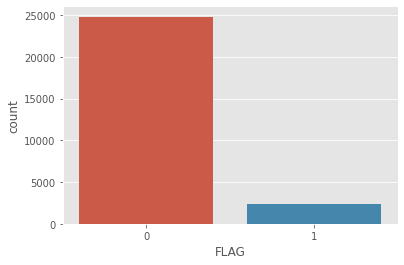

In [ ]:
# Prior to any resampling, the data should have a 91.5-8.5 split
counter_original = Counter(y_train)
print(counter_original)
countplot(y_train)

## Resampling - Standard Scaler Data 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24803, 1: 24803})


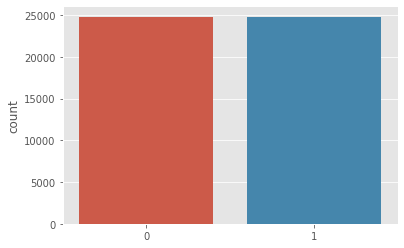

In [ ]:
# Standard SMOTE that will create synthetic minority samples for 50-50 split
oversample = SMOTE()
X_train_std_resampled, y_train_std_resampled = oversample.fit_resample(X_train_1D_std, 
                                                                       y_train)
print(Counter(y_train_std_resampled))
countplot(y_train_std_resampled)

## Resampling - MinMax Scaler Data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24803, 1: 24803})


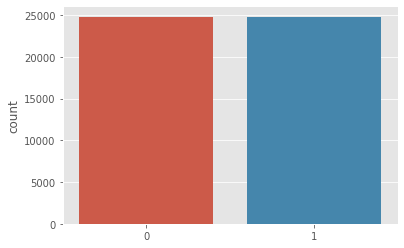

In [ ]:
# Standard SMOTE that will create synthetic minority samples for 50-50 split
oversample = SMOTE()
X_train_minmax_resampled, y_train_minmax_resampled = oversample.fit_resample(
    X_train_1D_minmax, y_train)
print(Counter(y_train_minmax_resampled))
countplot(y_train_minmax_resampled)

# WNN - SMOTE 

## Standard Scaler Data

Epoch 1/10
1551/1551 [==============================] - 6s 4ms/step - loss: 0.5280 - auc_6: 0.8104 - val_loss: 0.7693 - val_auc_6: 0.7154
Epoch 2/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.3763 - auc_6: 0.9087 - val_loss: 0.7459 - val_auc_6: 0.7132
Epoch 3/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.2979 - auc_6: 0.9441 - val_loss: 0.6316 - val_auc_6: 0.7159
Epoch 4/10
1551/1551 [==============================] - 5s 4ms/step - loss: 0.2539 - auc_6: 0.9593 - val_loss: 0.5013 - val_auc_6: 0.7075
Epoch 5/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.2224 - auc_6: 0.9689 - val_loss: 0.6130 - val_auc_6: 0.7055
Epoch 6/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.1968 - auc_6: 0.9756 - val_loss: 0.7304 - val_auc_6: 0.6992
Epoch 7/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.1795 - auc_6: 0.9797 - val_loss: 0.6682 - val_auc_6: 0.7006
Epoch 8/10
1551/1551 [============

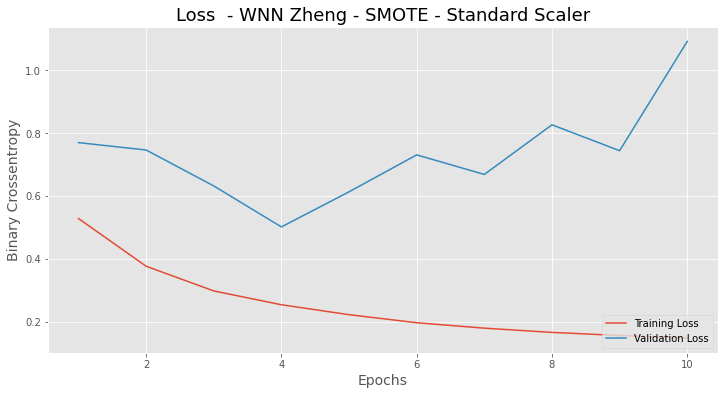

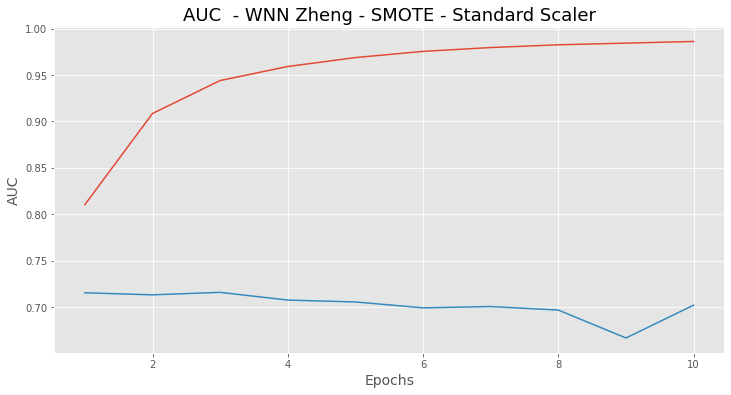

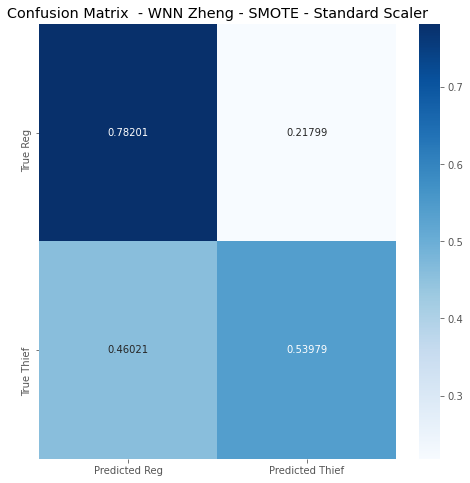

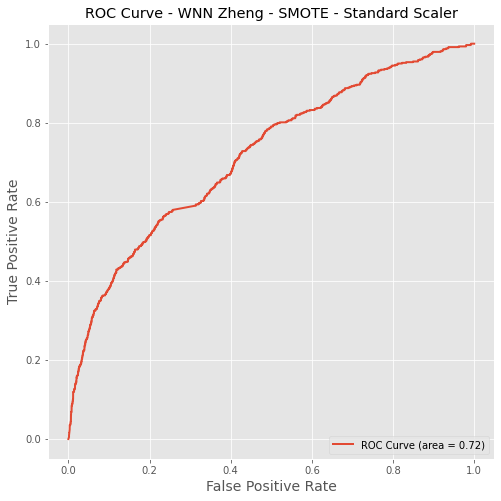

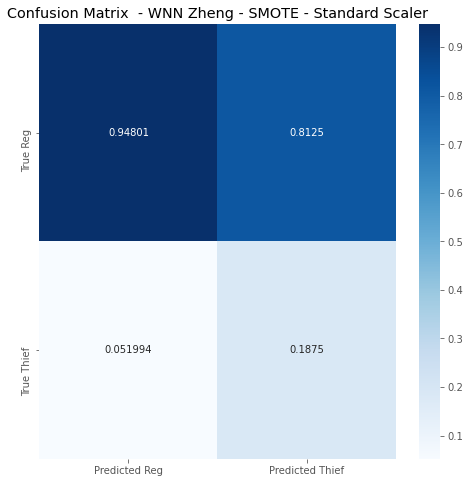

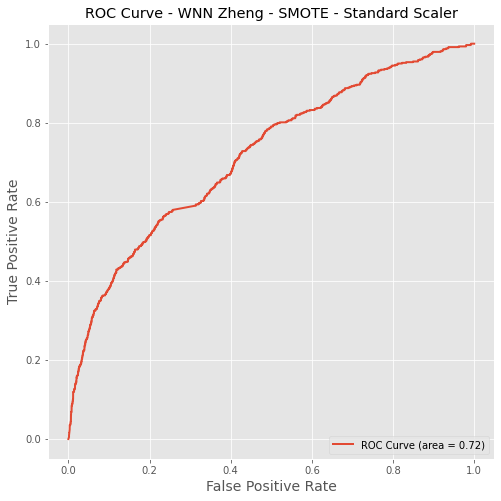

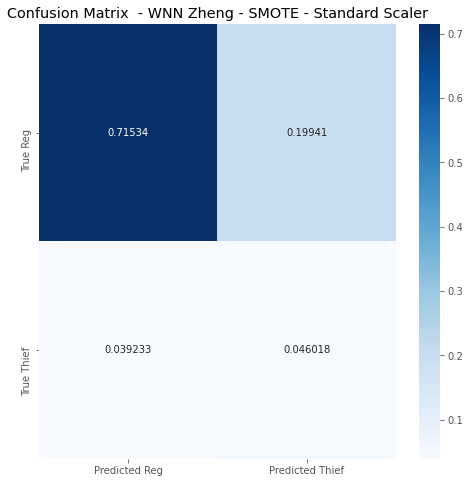

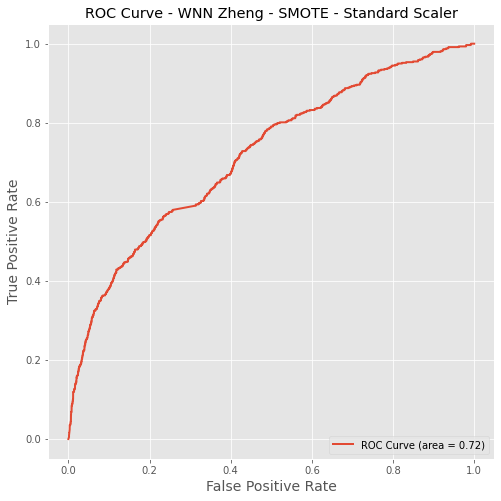

In [ ]:
train_and_evaluate_wnn(X_train=X_train_std_resampled, y_train=y_train_std_resampled, 
                       X_val=X_val_1D_std, y_val=y_val, 
                       model_name="WNN Zheng - SMOTE - Standard Scaler")

## MinMax Data

Epoch 1/10
1551/1551 [==============================] - 6s 4ms/step - loss: 0.5904 - auc_7: 0.7504 - val_loss: 0.5688 - val_auc_7: 0.6940
Epoch 2/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.4971 - auc_7: 0.8377 - val_loss: 0.3825 - val_auc_7: 0.7457
Epoch 3/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.4342 - auc_7: 0.8800 - val_loss: 0.4955 - val_auc_7: 0.7394
Epoch 4/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.3885 - auc_7: 0.9055 - val_loss: 0.3931 - val_auc_7: 0.7341
Epoch 5/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.3472 - auc_7: 0.9251 - val_loss: 0.4267 - val_auc_7: 0.7501
Epoch 6/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.3168 - auc_7: 0.9381 - val_loss: 0.3879 - val_auc_7: 0.7382
Epoch 7/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.2907 - auc_7: 0.9480 - val_loss: 0.3690 - val_auc_7: 0.7376
Epoch 8/10
1551/1551 [============

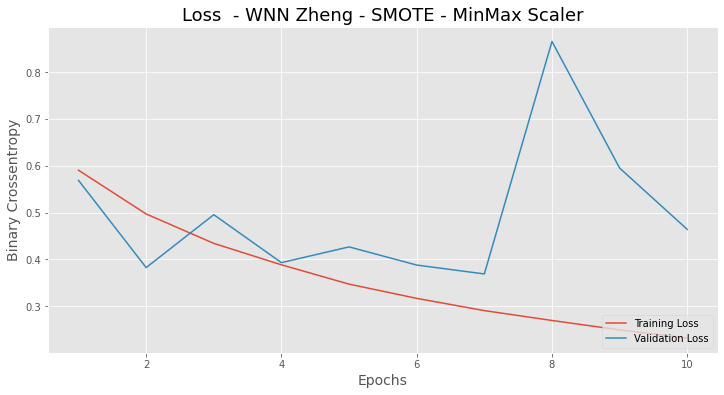

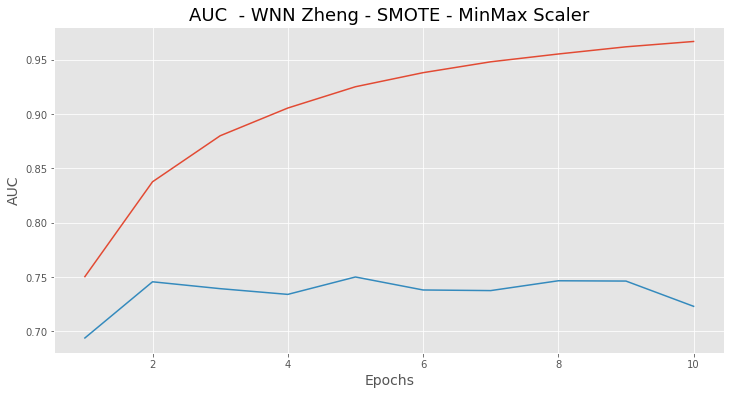

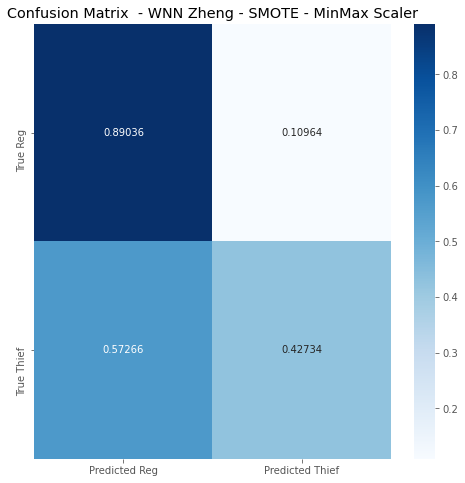

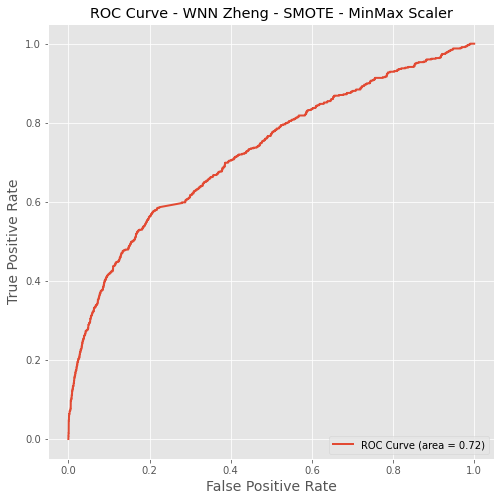

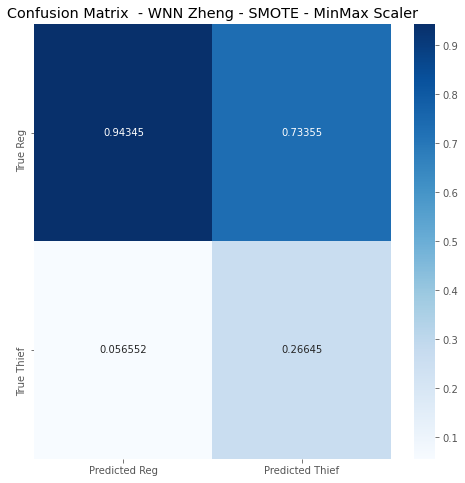

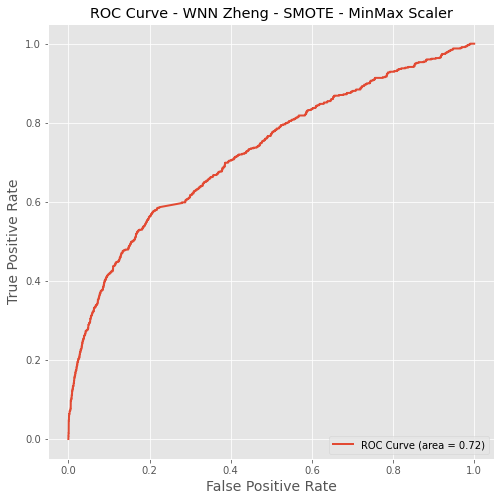

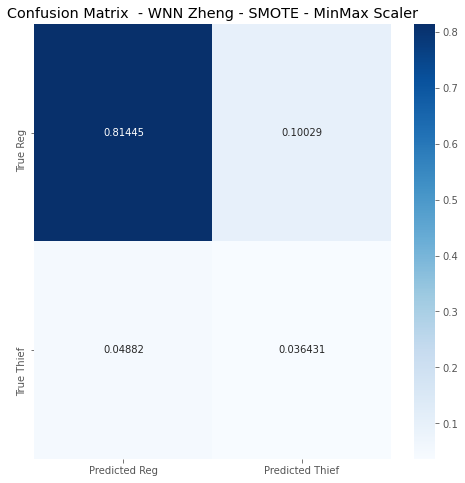

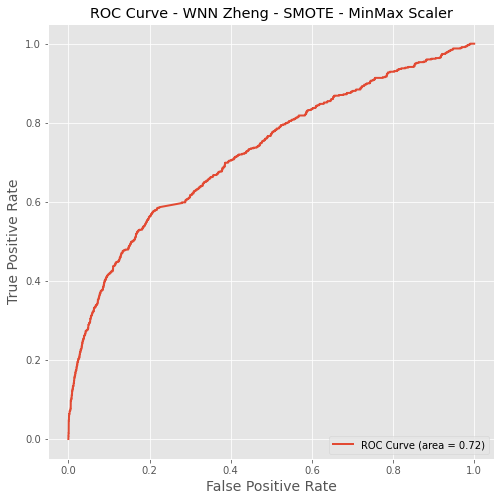

In [ ]:
train_and_evaluate_wnn(X_train_minmax_resampled, y_train_minmax_resampled, 
                       X_val_1D_minmax, y_val, 
                       "WNN Zheng - SMOTE - MinMax Scaler")

# SMOTE with Majority Undersampling

In [ ]:
# Oversample the minority class to have 40% as many samples as original majority class
oversampler = SMOTE(sampling_strategy=0.4)

# Undersample the minority class to have twice as many samples as minority class
undersampler = RandomUnderSampler(sampling_strategy=0.5)

# Create a pipeline with the two sampling steps
sampling_pipeline = Pipeline([('over', oversampler), ('under', undersampler)])

## Class Distribution before Resampling

Counter({0: 24803, 1: 2314})


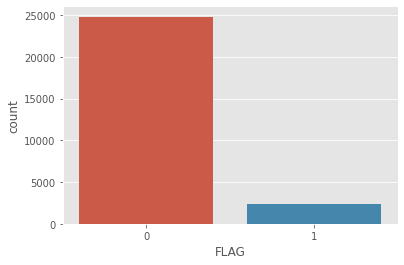

In [ ]:
counter = Counter(y_train) 
print(counter)
countplot(y_train)

## Resampling - Standard Scaler Data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 19842, 1: 9921})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


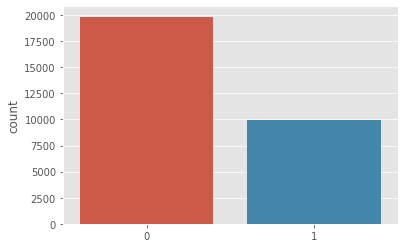

In [ ]:
X_train_std_resampled, y_train_std_resampled = sampling_pipeline.fit_resample(
    X_train_1D_std, y_train
)

print(Counter(y_train_std_resampled))
countplot(y_train_std_resampled)

## Resampling - MinMax Scaler Data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 19842, 1: 9921})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


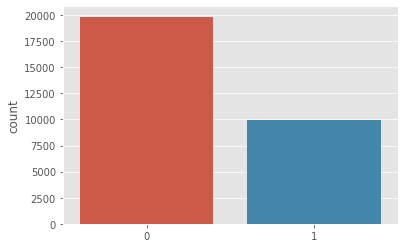

In [ ]:
X_train_minmax_resampled, y_train_minmax_resampled = sampling_pipeline.fit_resample(
    X_train_1D_minmax, y_train
)

print(Counter(y_train_minmax_resampled))
countplot(y_train_minmax_resampled)

# WNN - SMOTE with Majority Undersampling

## Standard Scaler Data

Epoch 1/10
931/931 [==============================] - 4s 4ms/step - loss: 0.5480 - auc_8: 0.7562 - val_loss: 0.3686 - val_auc_8: 0.6949
Epoch 2/10
931/931 [==============================] - 3s 4ms/step - loss: 0.4310 - auc_8: 0.8617 - val_loss: 0.3287 - val_auc_8: 0.7177
Epoch 3/10
931/931 [==============================] - 3s 4ms/step - loss: 0.3633 - auc_8: 0.9067 - val_loss: 0.4833 - val_auc_8: 0.7260
Epoch 4/10
931/931 [==============================] - 4s 4ms/step - loss: 0.3170 - auc_8: 0.9298 - val_loss: 0.4205 - val_auc_8: 0.7235
Epoch 5/10
931/931 [==============================] - 4s 4ms/step - loss: 0.2804 - auc_8: 0.9454 - val_loss: 0.5431 - val_auc_8: 0.7125
Epoch 6/10
931/931 [==============================] - 4s 4ms/step - loss: 0.2486 - auc_8: 0.9575 - val_loss: 0.4752 - val_auc_8: 0.7272
Epoch 7/10
931/931 [==============================] - 3s 4ms/step - loss: 0.2268 - auc_8: 0.9645 - val_loss: 0.4839 - val_auc_8: 0.6697
Epoch 8/10
931/931 [============================

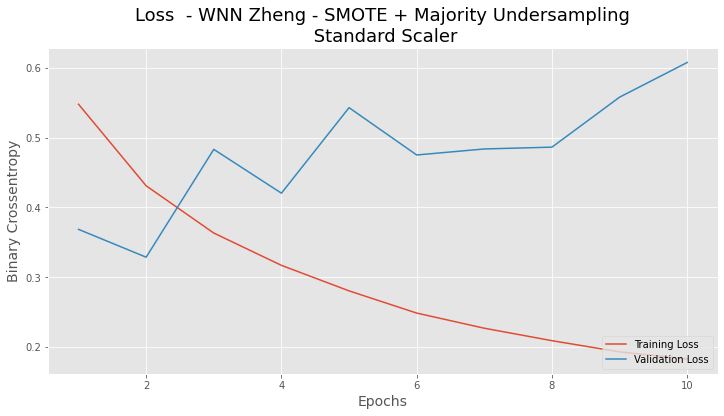

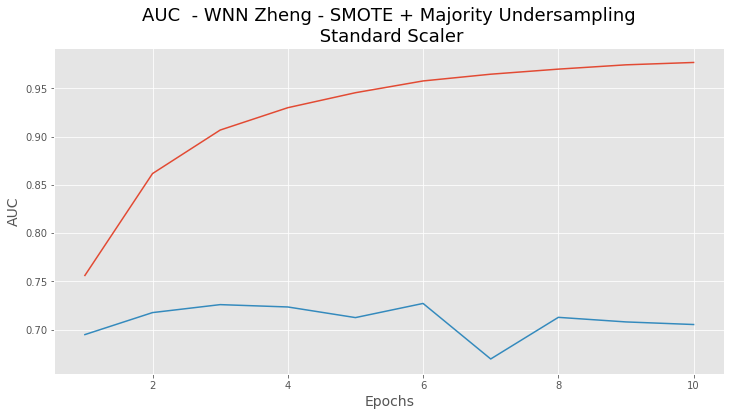

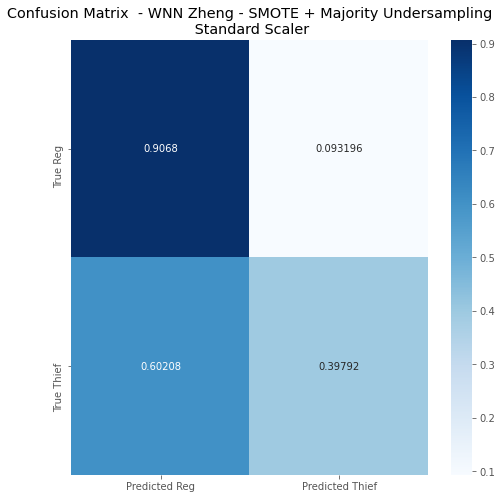

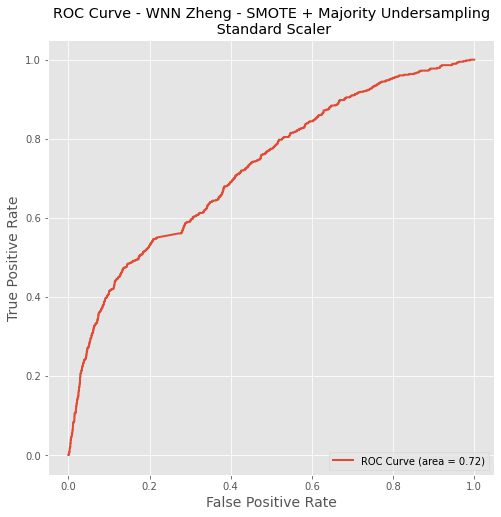

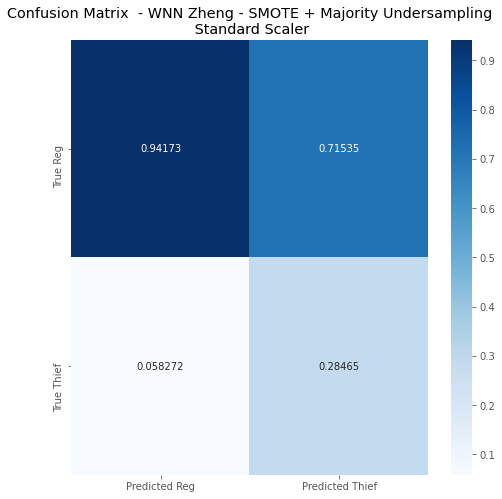

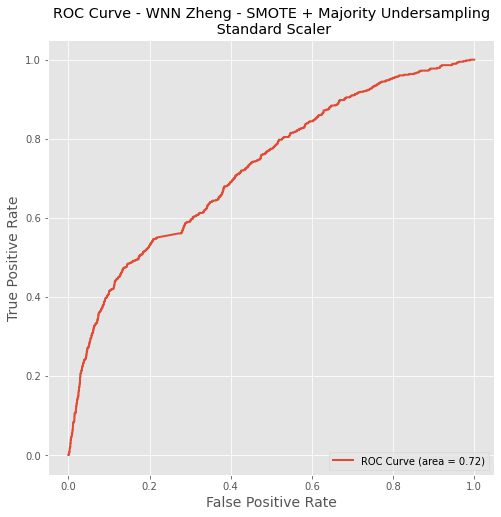

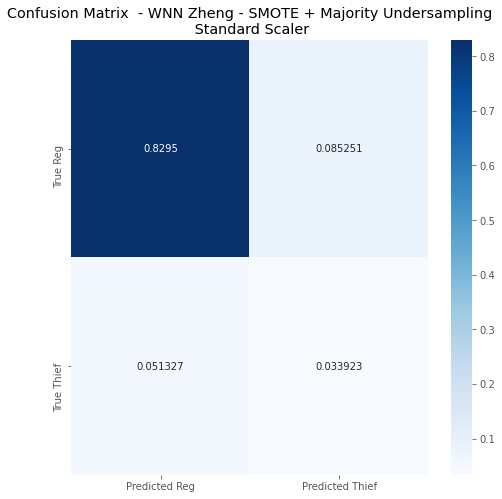

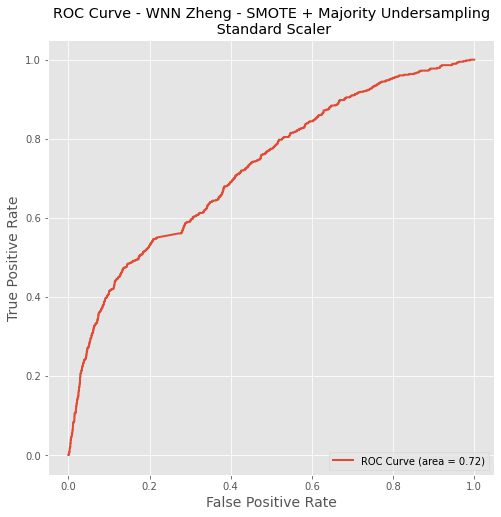

In [ ]:
train_and_evaluate_wnn(X_train_std_resampled, y_train_std_resampled, 
                       X_val_1D_std, y_val, 
                       "WNN Zheng - SMOTE + Majority Undersampling\n Standard Scaler")

## MinMax Scaler Data

Epoch 1/10
931/931 [==============================] - 4s 4ms/step - loss: 0.5754 - auc_9: 0.7058 - val_loss: 1.0320 - val_auc_9: 0.6764
Epoch 2/10
931/931 [==============================] - 3s 4ms/step - loss: 0.5111 - auc_9: 0.7885 - val_loss: 0.2748 - val_auc_9: 0.7359
Epoch 3/10
931/931 [==============================] - 3s 4ms/step - loss: 0.4722 - auc_9: 0.8269 - val_loss: 0.3928 - val_auc_9: 0.7311
Epoch 4/10
931/931 [==============================] - 3s 4ms/step - loss: 0.4424 - auc_9: 0.8513 - val_loss: 0.4912 - val_auc_9: 0.7441
Epoch 5/10
931/931 [==============================] - 3s 4ms/step - loss: 0.4140 - auc_9: 0.8722 - val_loss: 0.3488 - val_auc_9: 0.6924
Epoch 6/10
931/931 [==============================] - 3s 4ms/step - loss: 0.3921 - auc_9: 0.8866 - val_loss: 0.6099 - val_auc_9: 0.7079
Epoch 7/10
931/931 [==============================] - 3s 4ms/step - loss: 0.3681 - auc_9: 0.9019 - val_loss: 0.3186 - val_auc_9: 0.7459
Epoch 8/10
931/931 [============================

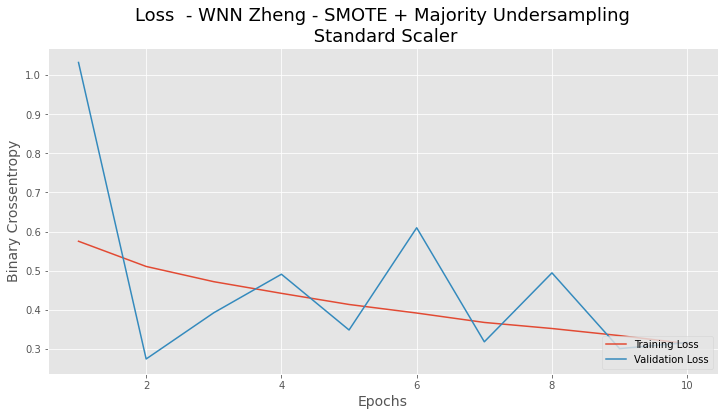

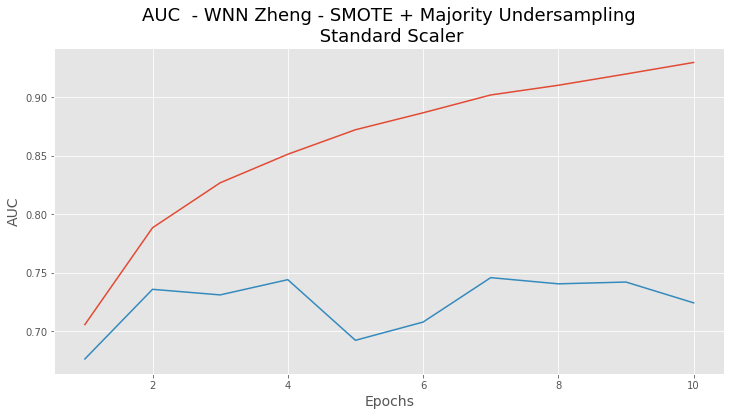

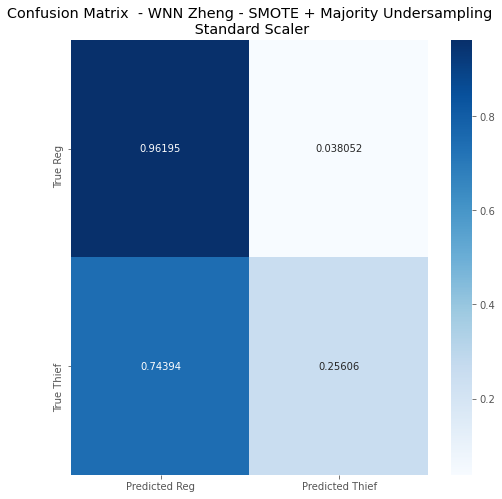

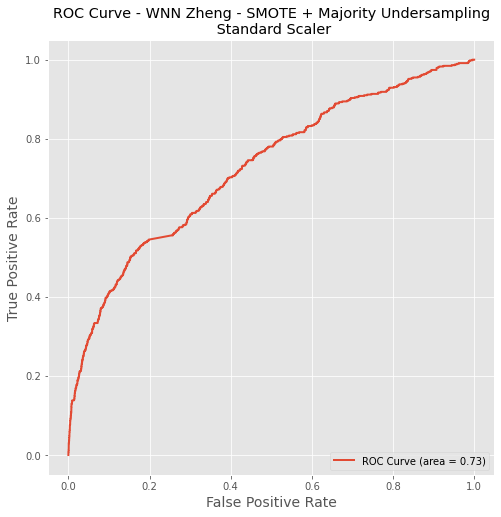

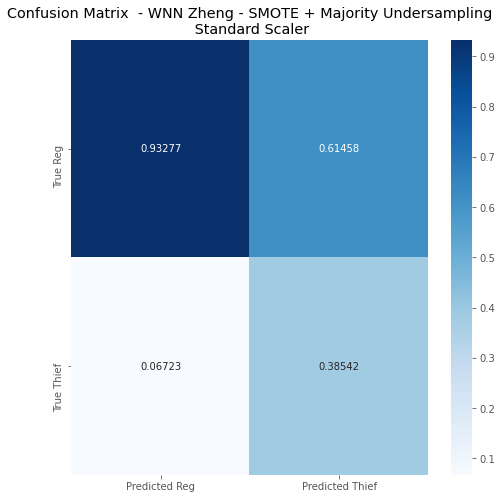

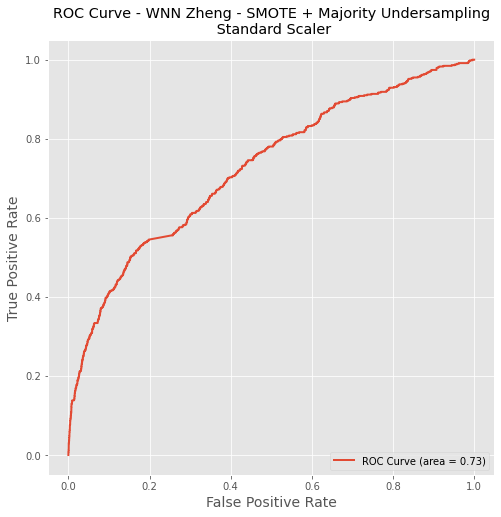

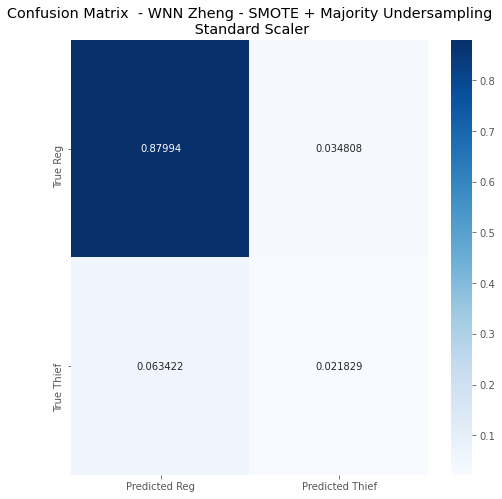

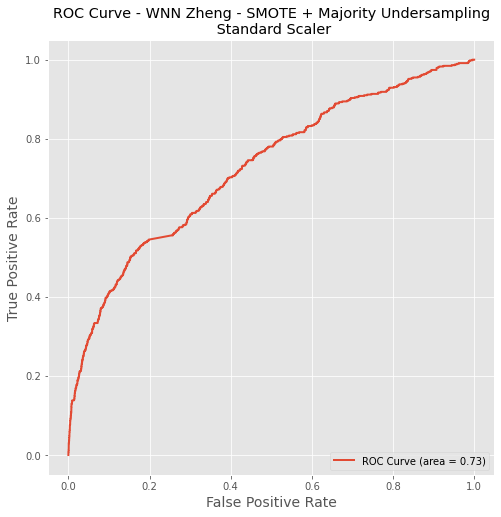

In [ ]:
train_and_evaluate_wnn(X_train_minmax_resampled, y_train_minmax_resampled, 
                       X_val_1D_minmax, y_val, 
                       "WNN Zheng - SMOTE + Majority Undersampling\n Standard Scaler")

# Borderline SMOTE

## Resampling - Standard Scaler Data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24803, 1: 24803})


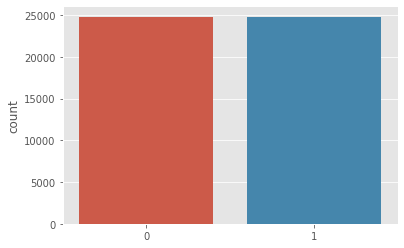

In [35]:
borderline_smote = BorderlineSMOTE() 
X_train_std_resampled, y_train_std_resampled = borderline_smote.fit_resample(
    X_train_1D_std, y_train
)

print(Counter(y_train_std_resampled))
countplot(y_train_std_resampled)

## Resampling - MinMax Scaler Data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24803, 1: 24803})


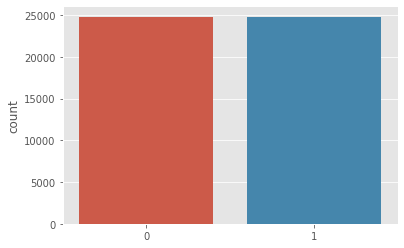

In [36]:
borderline_smote = BorderlineSMOTE() 
X_train_minmax_resampled, y_train_minmax_resampled = borderline_smote.fit_resample(
    X_train_1D_minmax, y_train
)

print(Counter(y_train_minmax_resampled))
countplot(y_train_minmax_resampled)

# WNN - Borderline SMOTE

## Standard Scaler Data

Epoch 1/10
1551/1551 [==============================] - 6s 4ms/step - loss: 0.4717 - auc_10: 0.8584 - val_loss: 0.5418 - val_auc_10: 0.7141
Epoch 2/10
1551/1551 [==============================] - 5s 4ms/step - loss: 0.3396 - auc_10: 0.9314 - val_loss: 0.3719 - val_auc_10: 0.7057
Epoch 3/10
1551/1551 [==============================] - 5s 4ms/step - loss: 0.2811 - auc_10: 0.9545 - val_loss: 0.4553 - val_auc_10: 0.7015
Epoch 4/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.2459 - auc_10: 0.9652 - val_loss: 0.6269 - val_auc_10: 0.7186
Epoch 5/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.2137 - auc_10: 0.9734 - val_loss: 0.5338 - val_auc_10: 0.7183
Epoch 6/10
1551/1551 [==============================] - 5s 4ms/step - loss: 0.1906 - auc_10: 0.9786 - val_loss: 0.7190 - val_auc_10: 0.6943
Epoch 7/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.1713 - auc_10: 0.9826 - val_loss: 0.7781 - val_auc_10: 0.7113
Epoch 8/10
1551/1551

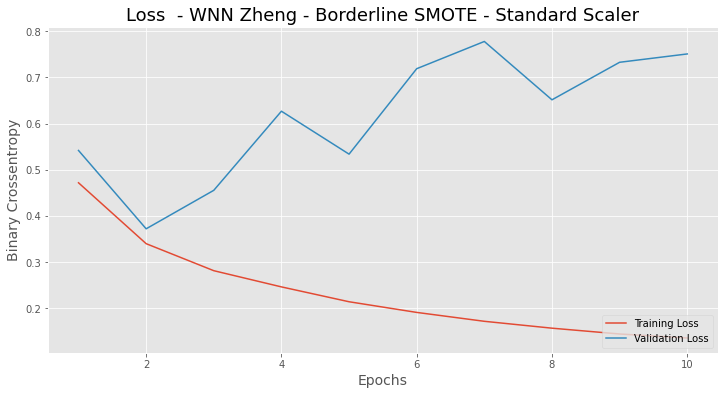

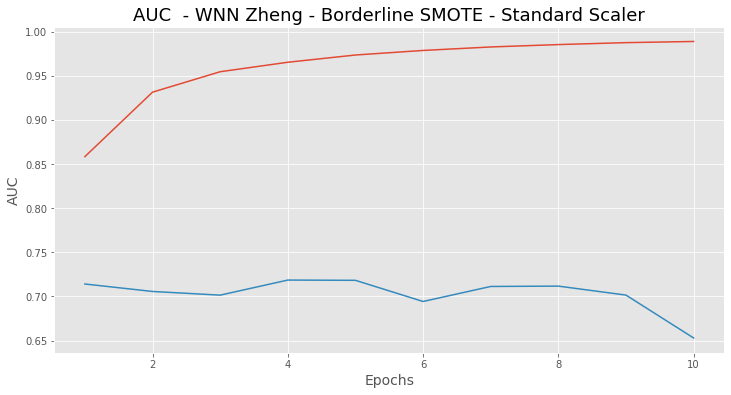

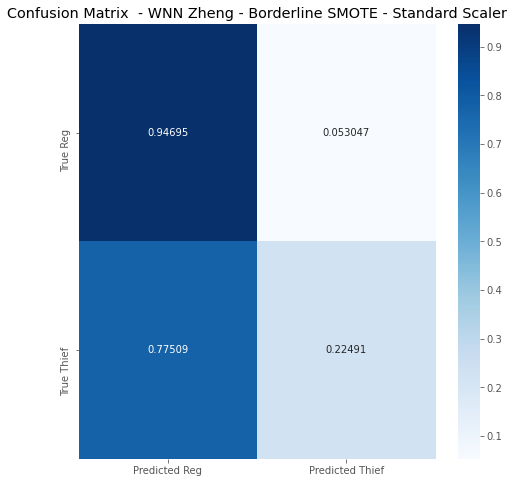

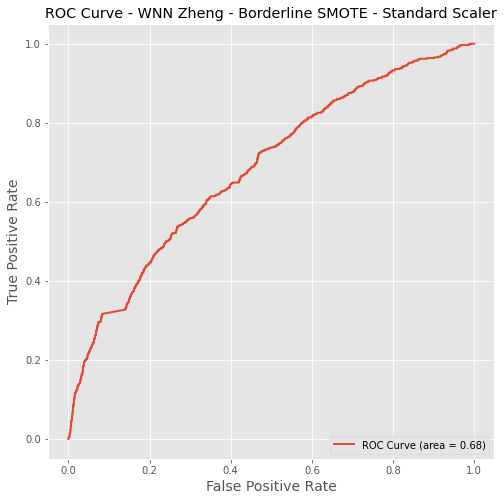

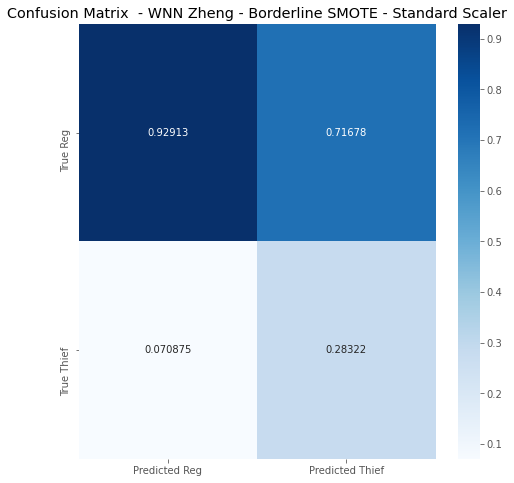

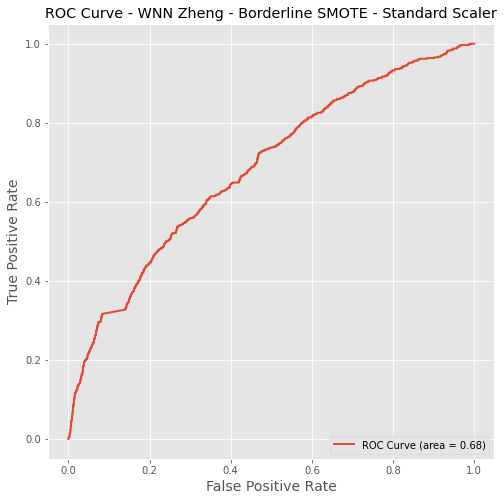

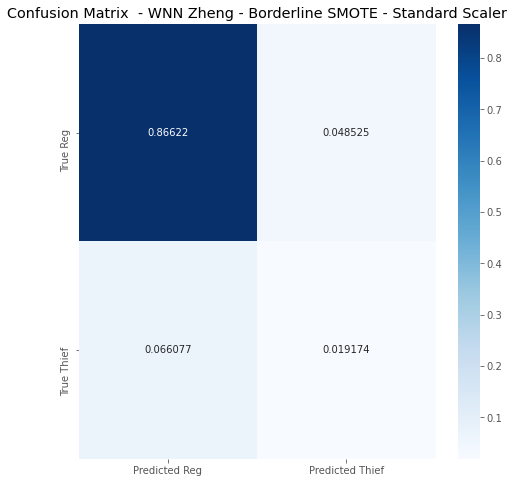

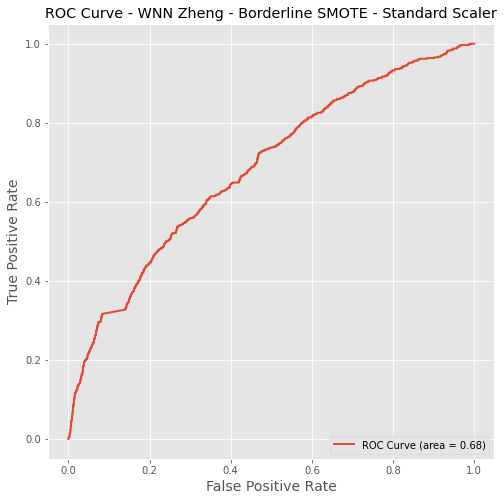

In [37]:
train_and_evaluate_wnn(X_train=X_train_std_resampled, y_train=y_train_std_resampled, 
                       X_val=X_val_1D_std, y_val=y_val, 
                       model_name="WNN Zheng - Borderline SMOTE - Standard Scaler")

## MinMax Scaler Data

Epoch 1/10
1551/1551 [==============================] - 6s 4ms/step - loss: 0.5462 - auc_11: 0.7962 - val_loss: 0.6541 - val_auc_11: 0.7197
Epoch 2/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.4320 - auc_11: 0.8817 - val_loss: 0.5610 - val_auc_11: 0.7436
Epoch 3/10
1551/1551 [==============================] - 5s 3ms/step - loss: 0.3705 - auc_11: 0.9150 - val_loss: 0.4084 - val_auc_11: 0.7553
Epoch 4/10
1551/1551 [==============================] - 5s 4ms/step - loss: 0.3260 - auc_11: 0.9349 - val_loss: 0.5840 - val_auc_11: 0.7480
Epoch 5/10
1551/1551 [==============================] - 5s 4ms/step - loss: 0.2928 - auc_11: 0.9480 - val_loss: 0.3711 - val_auc_11: 0.7404
Epoch 6/10
1551/1551 [==============================] - 5s 4ms/step - loss: 0.2655 - auc_11: 0.9575 - val_loss: 0.3456 - val_auc_11: 0.7421
Epoch 7/10
1551/1551 [==============================] - 5s 4ms/step - loss: 0.2456 - auc_11: 0.9636 - val_loss: 0.3553 - val_auc_11: 0.7544
Epoch 8/10
1551/1551

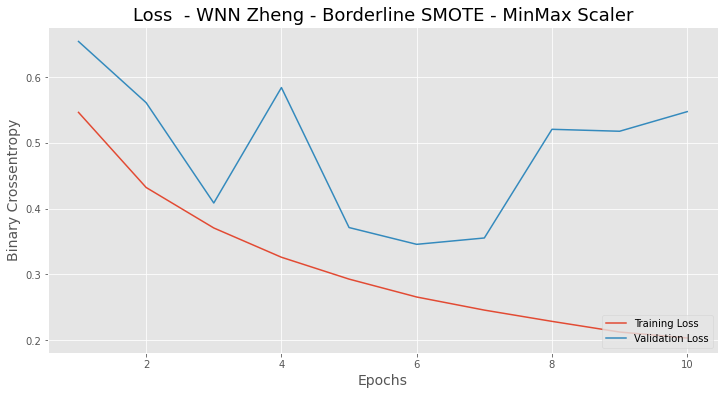

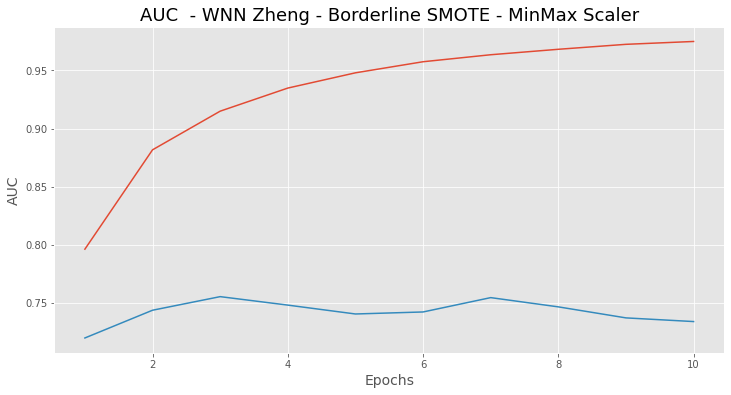

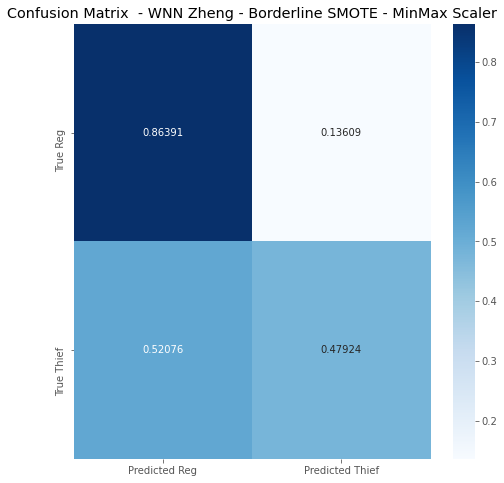

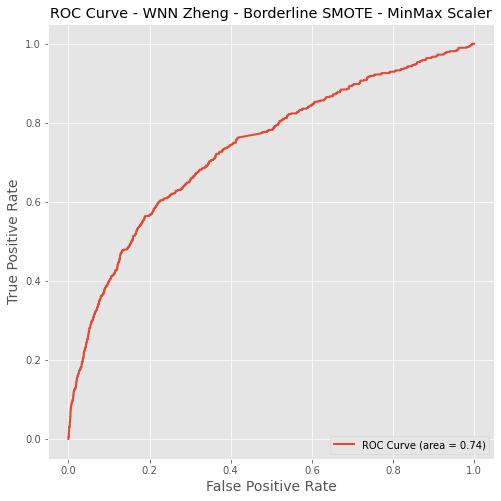

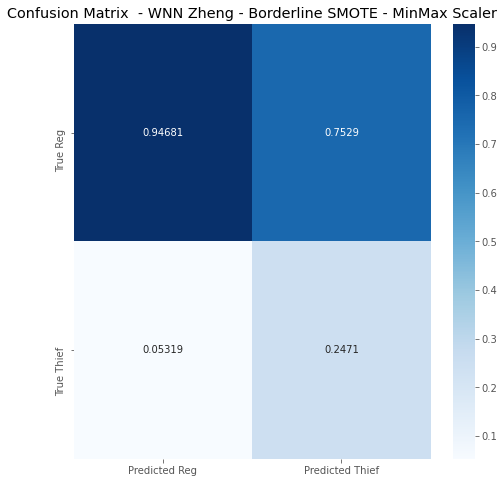

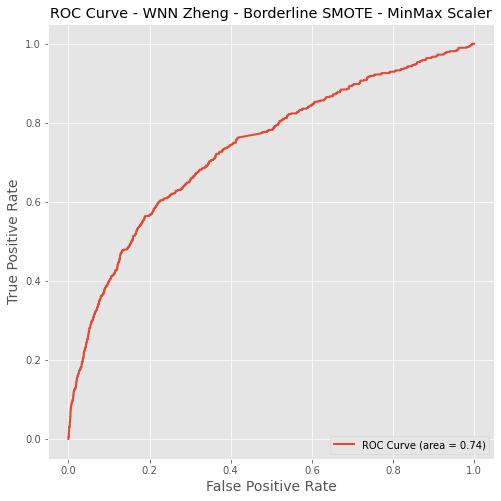

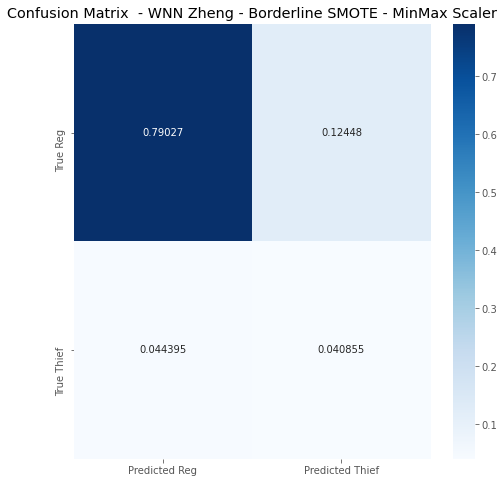

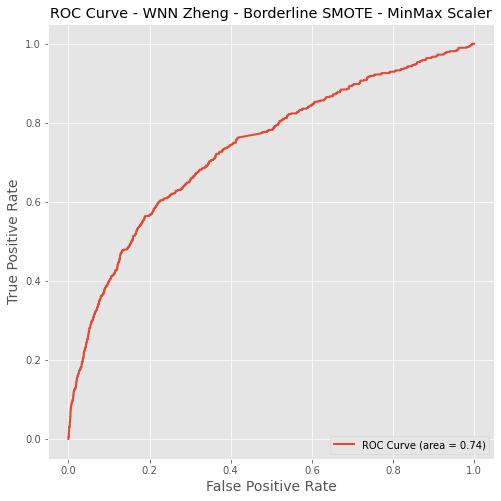

In [38]:
train_and_evaluate_wnn(X_train=X_train_minmax_resampled, y_train=y_train_minmax_resampled, 
                       X_val=X_val_1D_minmax, y_val=y_val, 
                       model_name="WNN Zheng - Borderline SMOTE - MinMax Scaler")

# ADASYN

## Resampling - Standard Scaler Data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24803, 1: 24690})


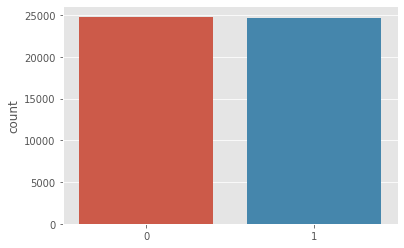

In [39]:
adasyn_std = ADASYN() 
X_train_std_resampled, y_train_std_resampled = adasyn_std.fit_resample(
    X_train_1D_std, y_train
)

print(Counter(y_train_std_resampled))
countplot(y_train_std_resampled)

## Resampling - MinMax Scaler Data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24803, 1: 24683})


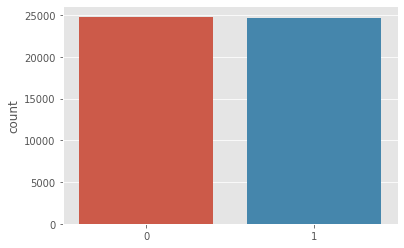

In [40]:
adasyn_minmax = ADASYN() 
X_train_minmax_resampled, y_train_minmax_resampled = adasyn_minmax.fit_resample(
    X_train_1D_minmax, y_train
)

print(Counter(y_train_minmax_resampled))
countplot(y_train_minmax_resampled)

# WNN - ADASYN

## Standard Scaler Data

Epoch 1/10
1547/1547 [==============================] - 6s 4ms/step - loss: 0.5398 - auc_12: 0.7983 - val_loss: 0.6401 - val_auc_12: 0.7065
Epoch 2/10
1547/1547 [==============================] - 6s 4ms/step - loss: 0.3834 - auc_12: 0.9043 - val_loss: 0.6673 - val_auc_12: 0.7139
Epoch 3/10
1547/1547 [==============================] - 6s 4ms/step - loss: 0.3077 - auc_12: 0.9396 - val_loss: 0.6607 - val_auc_12: 0.7163
Epoch 4/10
1547/1547 [==============================] - 5s 3ms/step - loss: 0.2578 - auc_12: 0.9578 - val_loss: 0.5948 - val_auc_12: 0.7084
Epoch 5/10
1547/1547 [==============================] - 5s 3ms/step - loss: 0.2277 - auc_12: 0.9671 - val_loss: 0.5166 - val_auc_12: 0.6946
Epoch 6/10
1547/1547 [==============================] - 5s 3ms/step - loss: 0.2033 - auc_12: 0.9739 - val_loss: 0.6326 - val_auc_12: 0.7111
Epoch 7/10
1547/1547 [==============================] - 5s 3ms/step - loss: 0.1828 - auc_12: 0.9790 - val_loss: 0.6949 - val_auc_12: 0.7062
Epoch 8/10
1547/1547

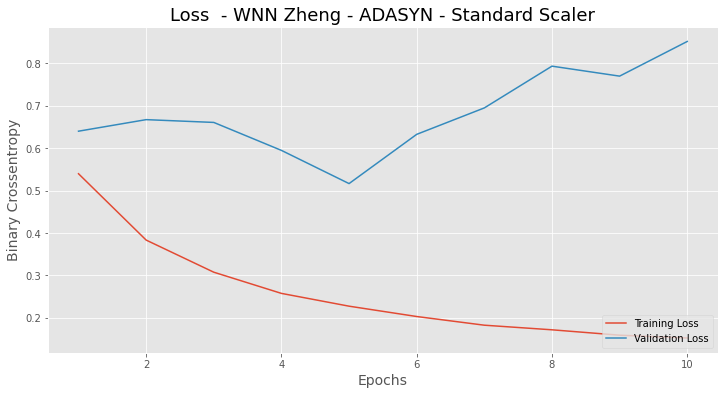

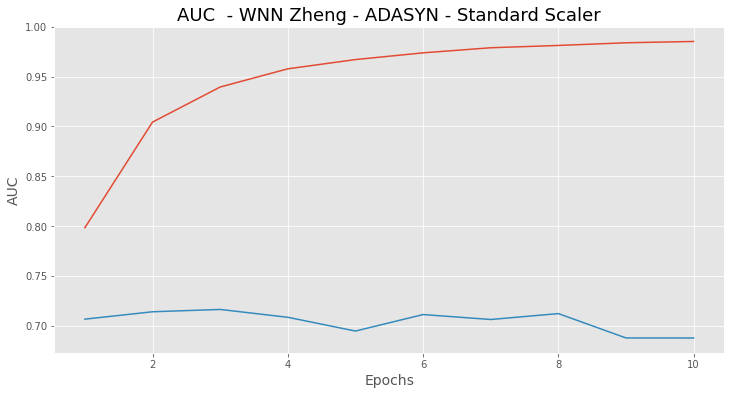

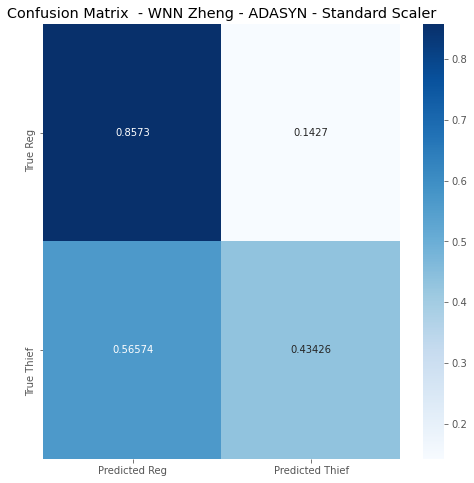

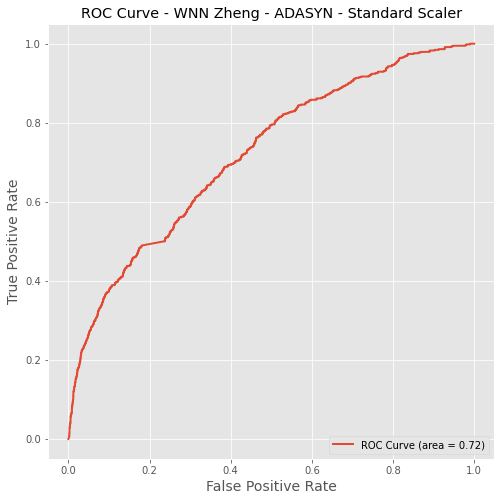

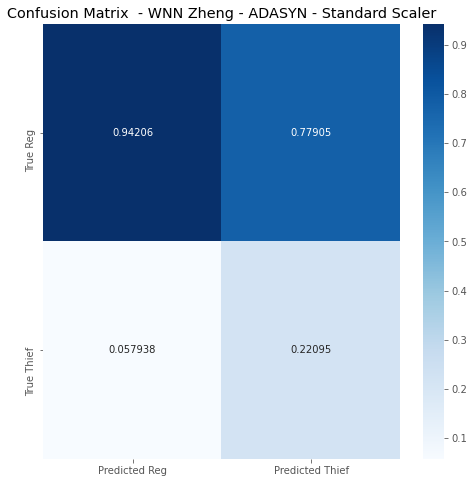

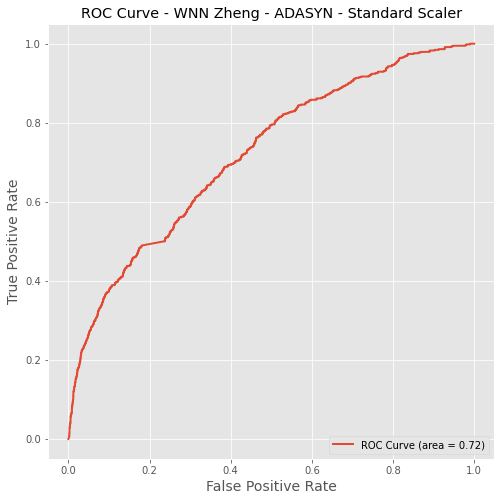

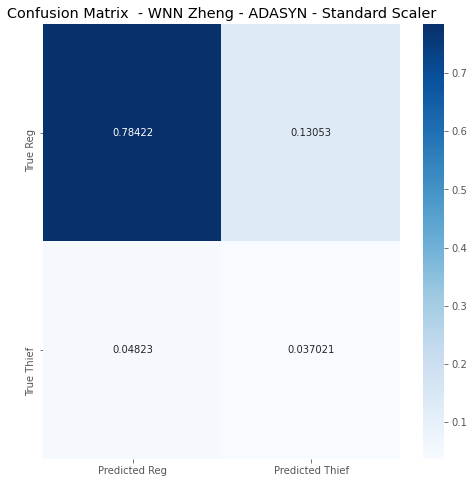

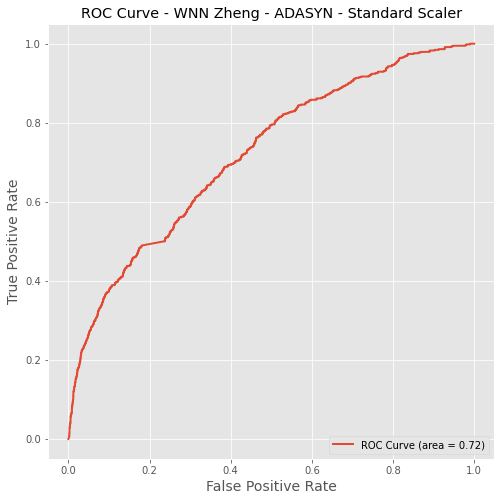

In [41]:
train_and_evaluate_wnn(X_train=X_train_std_resampled, y_train=y_train_std_resampled, 
                       X_val=X_val_1D_std, y_val=y_val, 
                       model_name="WNN Zheng - ADASYN - Standard Scaler")

## MinMax Scaler Data

Epoch 1/10
1547/1547 [==============================] - 6s 4ms/step - loss: 0.6140 - auc_13: 0.7190 - val_loss: 1.0583 - val_auc_13: 0.7364
Epoch 2/10
1547/1547 [==============================] - 5s 3ms/step - loss: 0.5247 - auc_13: 0.8147 - val_loss: 0.9606 - val_auc_13: 0.7075
Epoch 3/10
1547/1547 [==============================] - 5s 3ms/step - loss: 0.4622 - auc_13: 0.8614 - val_loss: 0.5260 - val_auc_13: 0.7561
Epoch 4/10
1547/1547 [==============================] - 5s 3ms/step - loss: 0.4103 - auc_13: 0.8931 - val_loss: 0.4910 - val_auc_13: 0.7572
Epoch 5/10
1547/1547 [==============================] - 5s 4ms/step - loss: 0.3693 - auc_13: 0.9143 - val_loss: 0.4312 - val_auc_13: 0.7468
Epoch 6/10
1547/1547 [==============================] - 5s 4ms/step - loss: 0.3375 - auc_13: 0.9290 - val_loss: 0.4185 - val_auc_13: 0.7501
Epoch 7/10
1547/1547 [==============================] - 5s 3ms/step - loss: 0.3101 - auc_13: 0.9405 - val_loss: 0.4444 - val_auc_13: 0.7458
Epoch 8/10
1547/1547

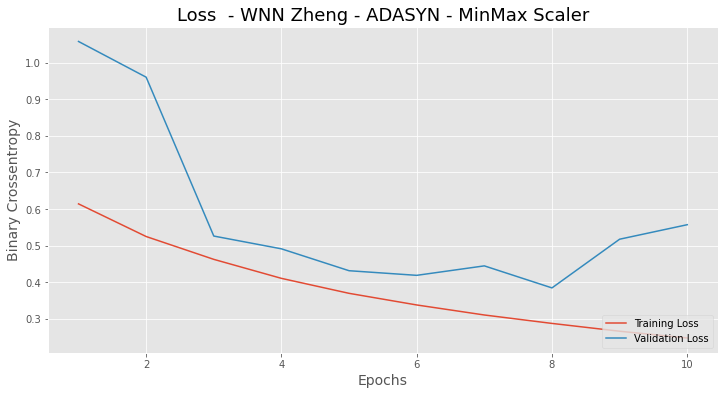

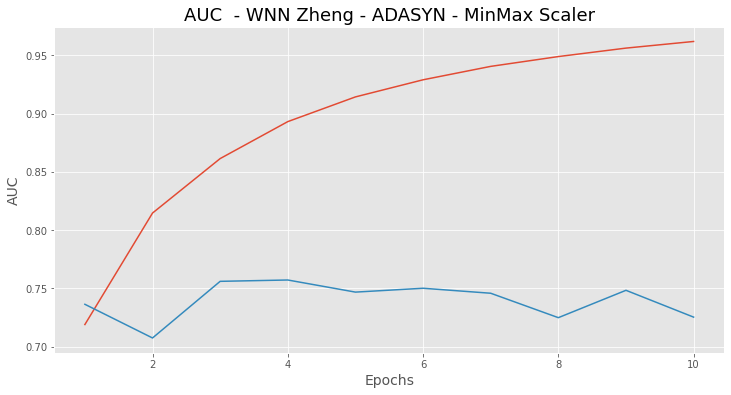

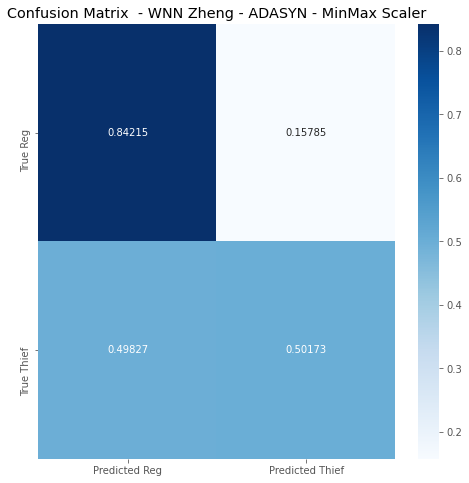

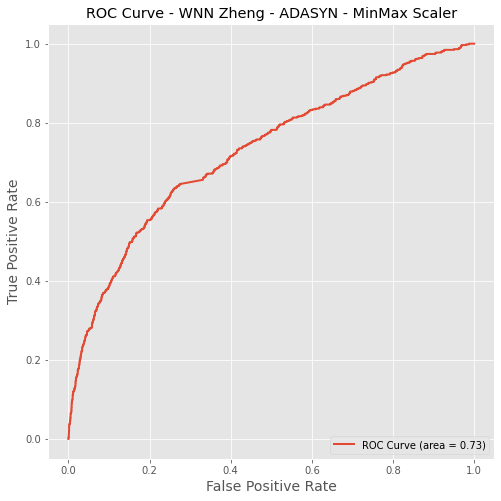

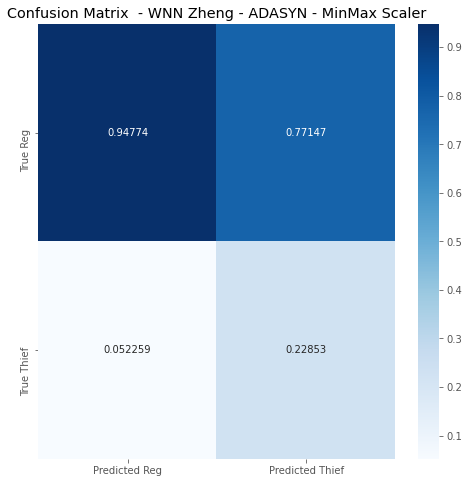

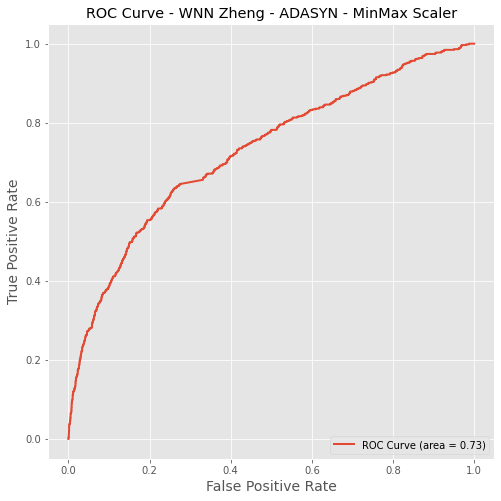

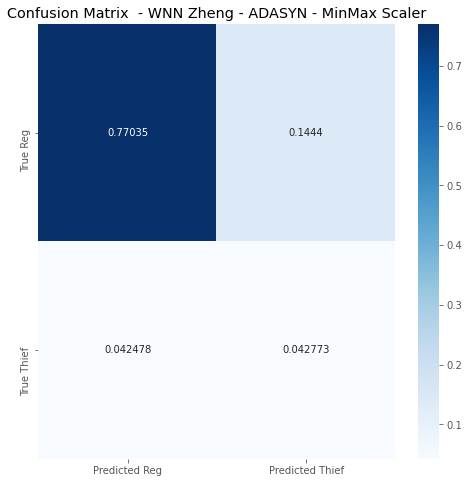

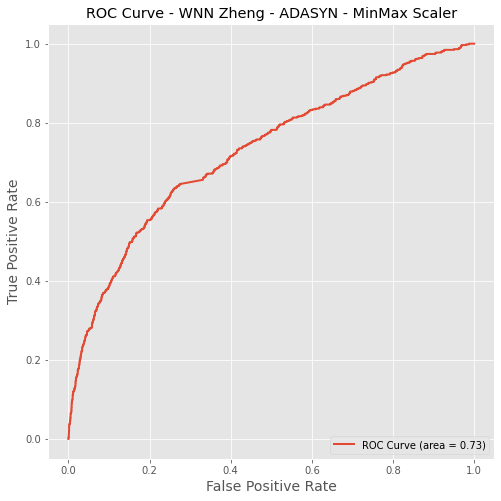

In [42]:
train_and_evaluate_wnn(X_train=X_train_minmax_resampled, y_train=y_train_minmax_resampled, 
                       X_val=X_val_1D_minmax, y_val=y_val, 
                       model_name="WNN Zheng - ADASYN - MinMax Scaler")